In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.pardir)

import gc
import joblib
import pdb

In [3]:
import numpy as np
import torch
import umap

In [4]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})
import seaborn as sns

In [5]:
from data.dataset import bird_dataset_single_hdf

In [9]:
from utils.utils import load_netG, overlap_encode, overlap_decode, segment_image, load_netE

In [10]:
from hmmlearn.hmm import GaussianHMM

In [11]:
from hmm.hmm_utils import generate_samples

# load a bird, get its songs from some day

In [12]:
dataset = bird_dataset_single_hdf('/home/songbird/datapartition/all_birds.hdf', 'p20r16')

... total number of folders for bird p20r16 = 35 ...


In [13]:
# choose a day
X = dataset.get(day=10, nsamps=-1)

In [14]:
Xtutor = dataset.get(day='tutor', nsamps=-1)

In [15]:
len(X)

1464

In [16]:
len(Xtutor)

0

In [23]:
X[0].shape

(129, 133)

# flatten and stack these 

In [17]:
X_real = np.concatenate([x.T for x in X])

In [18]:
X_real.shape

(842438, 129)

# optionally, encode real spectrograms

In [21]:
netE = load_netE('/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets_ngf64/netE_epoch_60_day_all.pth',
                 nz=12, ngf=64, cuda=True, resnet=True)

In [22]:
Z_real = [overlap_encode(x, netE, transform_sample=False, imageW=16, cuda=True) for x in X]    

In [23]:
Z_real = np.concatenate(Z_real)
Z_real.shape

(51982, 12)

In [25]:
del netE
gc.collect()

1950

# create generator, generate samples

In [24]:
from models.generative_model import GaussHMMGAN

In [29]:
model = GaussHMMGAN(netGpath='/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets_ngf64/netG_epoch_60_day_all.pth',
                   netEpath='/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets_ngf64/netE_epoch_60_day_all.pth',
        hmmpath='/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets_ngf64/day_10/hmm_hiddensize_100/model_day_10.pkl',
                   ngf=64
                   )

In [30]:
timesteps_per_sample = [x.shape[1]//16 for x in X]

In [31]:
# generate latent samples
latent_space_samples = model.sample_latent(nsamples=len(X), timesteps=timesteps_per_sample)

/home/songbird/code/birdsong_gan/birdsong_gan/hmm/hmm_utils.py:57: RuntimeWarning: divide by zero encountered in log
  p = np.exp(beta * np.log(a))


In [33]:
Z = [model.decode(z) for z in latent_space_samples]

In [35]:
Z = [z[0] for z in Z]

In [36]:
# flatten them into vectors
Z = np.concatenate([z.T for z in Z])
Z.shape

(831712, 129)

# Generate samples purely from the latent space of the GAN (no sequence)

In [ ]:
# generate some random numbers
Z = 2.*np.random.randn(200000, 12)

#Z = -10 + 20*np.random.rand(200000, 12)
Z.shape

In [115]:
# now decode
Xhat,_ = overlap_decode(Z, netG)

In [116]:
Xhat.shape

(129, 3200000)

In [117]:
segs = segment_image(Xhat, width=16)
Xhat = [np.ndarray.flatten(s) for s in segs]
del segs
gc.collect()

34

In [118]:
Xhat = np.stack(Xhat,axis=0)

In [119]:
Xhat.shape

(200000, 2064)

# project on umap

In [37]:
from umap import UMAP

In [38]:
umaplearner = UMAP(n_neighbors=15, n_components=2, min_dist = 0.01)

In [ ]:
xreal = umaplearner.fit_transform(X_real)

In [ ]:
xreal.shape

In [ ]:
xreal2 = umaplearner.transform(X_real)

In [60]:
xfake = umaplearner.transform(Z)

/home/songbird/anaconda3/envs/pytorch_gpu/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [73]:
xfake = umaplearner.transform(X_tut)

/home/songbird/anaconda3/envs/pytorch_gpu/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [74]:
xfake.shape

(426047, 2)

# learn umap in the latent space

In [34]:
zreal = umaplearner.fit_transform(Z_real)

In [35]:
zreal.shape

(61557, 2)

In [36]:
zfake = umaplearner.transform(Z)
zfake.shape

(61557, 2)

# Plot real and fake together

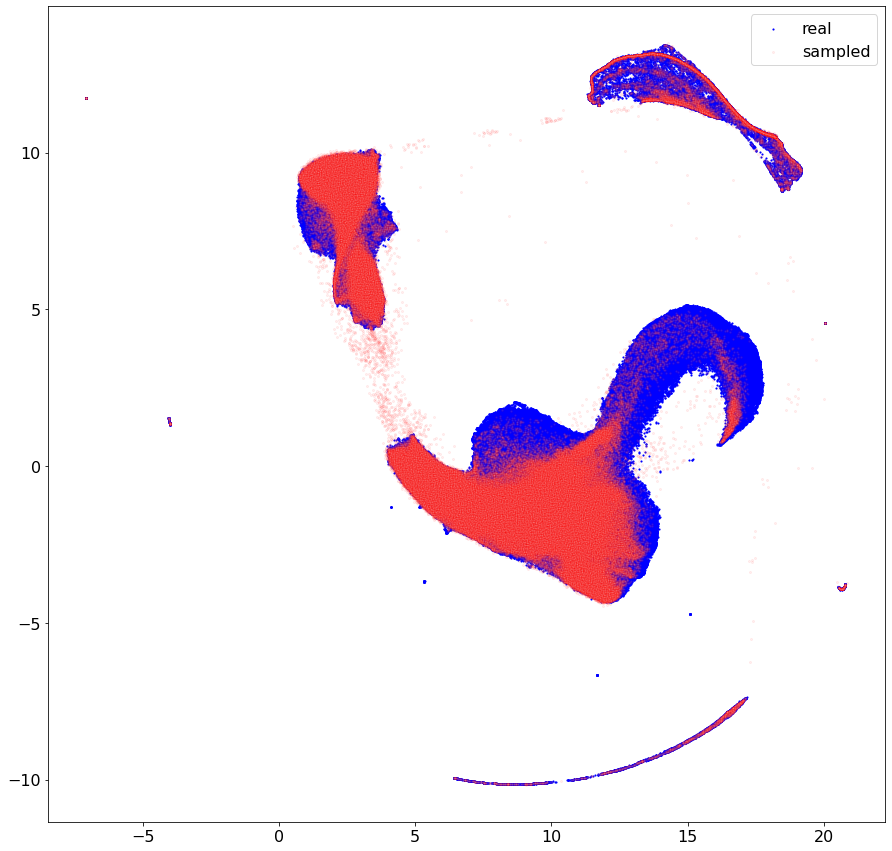

In [77]:
plt.figure(figsize=(12,12))


plt.scatter(xreal[:,0], xreal[:,1], s = 5, c = 'b', marker='.', )
plt.scatter(xfake[:,0], xfake[:,1], s = 3, c = 'w', marker='o', edgecolors='r', alpha=0.1)
plt.legend(['real', 'sampled'])

#plt.savefig('/home/songbird/Dropbox/Work/MDGAN_paper/Figures_for_paper/Final_figures/Figure2/r15y5_umap_nz12_day18_tutor_vs_real.jpg',
#            format='jpg', dpi=200)
#plt.close()

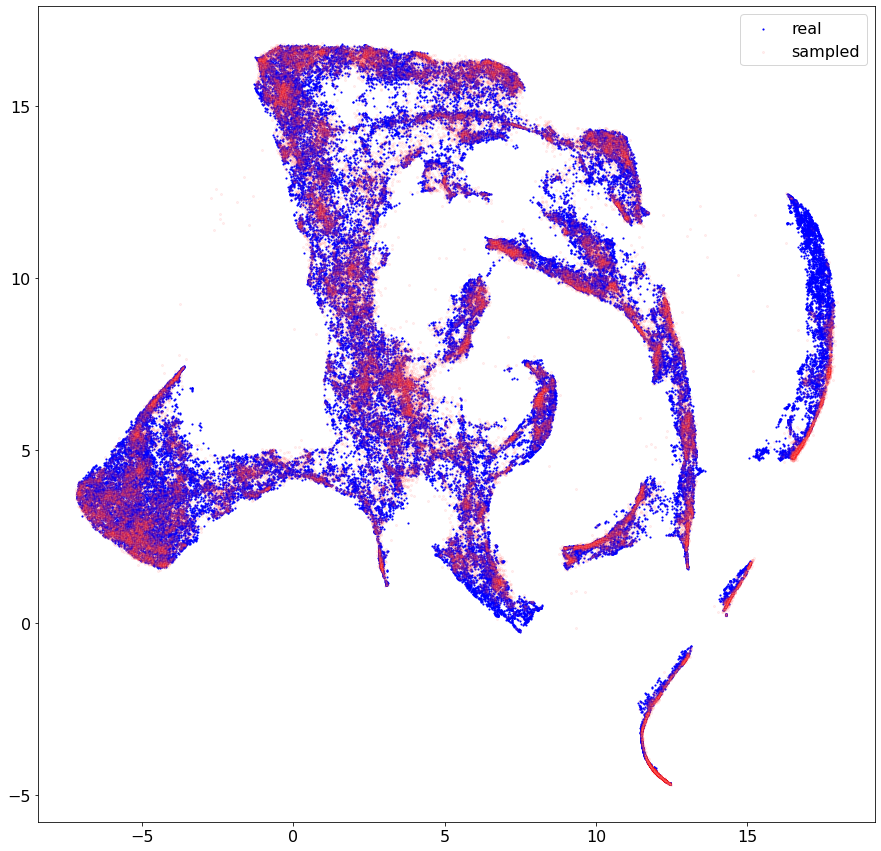

In [39]:
plt.figure(figsize=(15,15))
plt.scatter(zreal[:,0], zreal[:,1], s = 5, c = 'b', marker='.', )
plt.scatter(zfake[:,0], zfake[:,1], s = 3, c = 'w', marker='o', edgecolors='r', alpha=0.1)
plt.legend(['real', 'sampled'])
#plt.show()
#plt.savefig('/home/songbird/Dropbox/Work/MDGAN_paper/Figures_for_paper/Final_figures/Figure2/r15y5_umap_nz12_latentspace_day18_hmm100_vs_real.jpg',
#            format='jpg', dpi=200)
#plt.close()

In [40]:
import seaborn as sns

In [41]:
import pandas as pd

In [109]:
df_real = pd.DataFrame({'x1': xreal2[:,0], 'x2': xreal2[:,1]})
df_fake = pd.DataFrame({'x1': xfake2[:,0], 'x2': xfake2[:,1]})


In [42]:
df_real = pd.DataFrame({'x1': zreal[:,0], 'x2': zreal[:,1]})
df_fake = pd.DataFrame({'x1': zfake[:,0], 'x2': zfake[:,1]})


<Figure size 1080x1080 with 0 Axes>

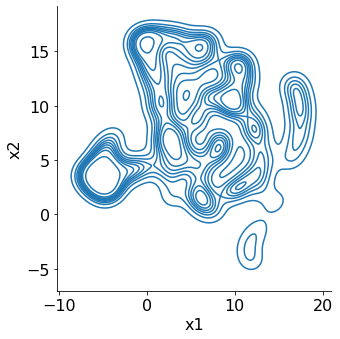

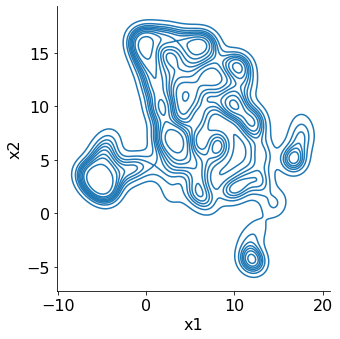

In [43]:
plt.figure(figsize=(15,15))
sns.displot(df_real, x="x1", y="x2", kind="kde")
sns.displot(df_fake, x="x1", y="x2", kind="kde")